<a href="https://colab.research.google.com/github/pacomm5/curso-series-temporales/blob/master/8.%20ARIMA%20autorregresivo%20integrado%20de%20medias%20moviles/Python/12_SARIMA_Predicciones.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SARIMA(p,d,q)(P,D,Q,s)
# Seasonal Autoregressive Integrated Moving Averages


In [1]:
import pandas as pd
import numpy as np
%matplotlib inline

# Herramientas
from statsmodels.tsa.statespace.sarimax import SARIMAX

from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # (p,q) orders
from statsmodels.tsa.seasonal import seasonal_decompose      # ETS Plots
                            

# Warnings
import warnings
warnings.filterwarnings("ignore")

# Dataset
df = pd.read_csv('https://raw.githubusercontent.com/MaddoSaru/curso-series-temporales/master/8.%20ARIMA%20autorregresivo%20integrado%20de%20medias%20moviles/Python/co2_mm_mlo.csv')

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
df.head()

year  month  decimal_date  average  interpolated       date
0  1958      3      1958.208   315.71        315.71 1958-03-01
1  1958      4      1958.292   317.45        317.45 1958-04-01
2  1958      5      1958.375   317.50        317.50 1958-05-01
3  1958      6      1958.458      NaN        317.10 1958-06-01
4  1958      7      1958.542   315.86        315.86 1958-07-01

In [ ]:
# Añadir una variable "date"
df['date']=pd.to_datetime(dict(year=df['year'], month=df['month'], day=1))

In [ ]:
# Hacer que la variable "date" sea el indice
df.set_index('date',inplace=True)
df.index.freq = 'MS'
df.head()

year  month  decimal_date  average  interpolated
date                                                        
1958-03-01  1958      3      1958.208   315.71        315.71
1958-04-01  1958      4      1958.292   317.45        317.45
1958-05-01  1958      5      1958.375   317.50        317.50
1958-06-01  1958      6      1958.458      NaN        317.10
1958-07-01  1958      7      1958.542   315.86        315.86

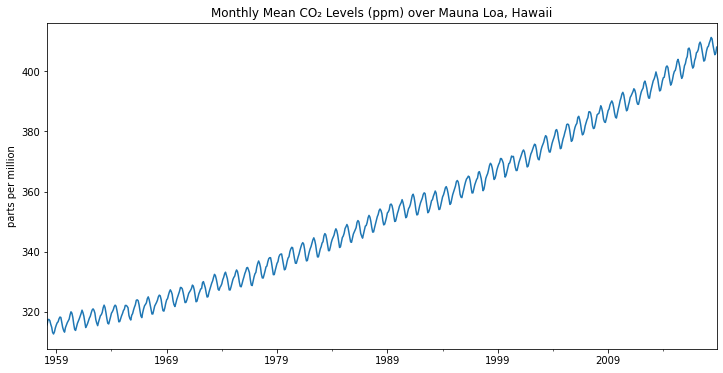

In [ ]:
title = 'Monthly Mean CO₂ Levels (ppm) over Mauna Loa, Hawaii'
ylabel='parts per million'
xlabel='' 

ax = df['interpolated'].plot(figsize=(12,6),title=title)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

### Descomposición en 3 factores

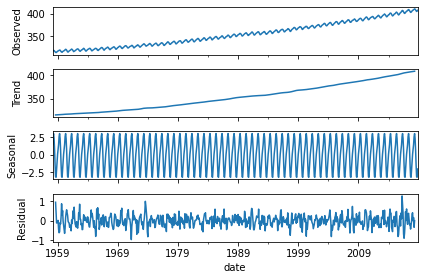

In [ ]:
result = seasonal_decompose(df['interpolated'], model='add')
result.plot();

Aunque sea pequeña en comparación con la escala de los datos, hay una estacionalidad anual.

### Dividir en datos de entrenamiento y prueba

In [ ]:
len(df)

729

In [ ]:
# Prueba
train = df.iloc[:717]
test = df.iloc[717:]

### Modelo SARIMA(0,1,1)(1,0,1,12) 

In [ ]:
model = SARIMAX(train['interpolated'],order=(0,1,1),seasonal_order=(1,0,1,12))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                       interpolated   No. Observations:                  717
Model:             SARIMAX(0, 1, 1)x(1, 0, 1, 12)   Log Likelihood                -205.148
Date:                            Tue, 11 Aug 2020   AIC                            418.296
Time:                                    16:02:03   BIC                            436.591
Sample:                                03-01-1958   HQIC                           425.361
                                     - 11-01-2017                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3711      0.034    -10.878      0.000      -0.438      -0.304
ar.S.L12       0.9997      0.000   3239.402      0.000       0.999       1.000
ma.S.L12      -0.8649      0.023    -37.857      0.000      -0.910      -0.820
sigma2         0.0960      0.005     20.209      0.000       0.087       0.105
===================================================================================
Ljung-Box (Q):                       51.97   Jarque-Bera (JB):                 3.79
Prob(Q):                              0.10   Prob(JB):                         0.15
Heteroskedasticity (H):               1.13   Skew:                            -0.02
Prob(H) (two-sided):                  0.35   Kurtosis:                         3.35
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
# Obtain predicted values
start=len(train)
end=len(train)+len(test)-1
predictions = results.predict(start=start, end=end).rename('SARIMA(0,1,1)(1,0,1,12) Predictions')

In [ ]:
# Compare predictions to expected values
for i in range(len(predictions)):
    print(f"predicted={predictions[i]:<11.10}, expected={test['interpolated'][i]}")

predicted=406.583566 , expected=406.81
predicted=407.7860264, expected=407.96
predicted=408.5313352, expected=408.32
predicted=409.4367906, expected=409.41
predicted=410.9960711, expected=410.24
predicted=411.5996603, expected=411.24
predicted=410.8183698, expected=410.79
predicted=409.1267968, expected=408.71
predicted=407.02577  , expected=406.99
predicted=405.5753509, expected=405.51
predicted=405.8469008, expected=406.0
predicted=407.3819349, expected=408.02


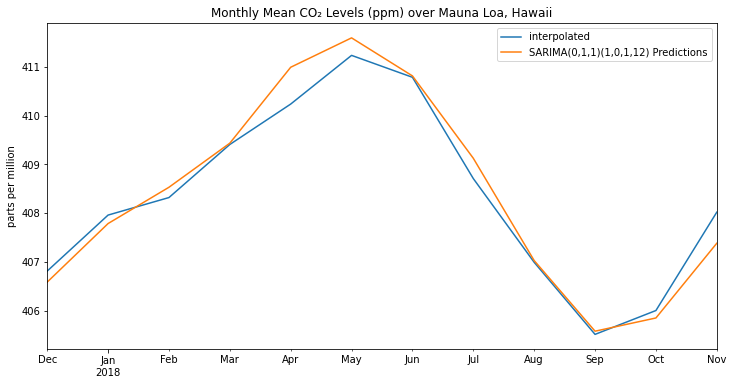

In [ ]:
# Plot predictions against known values
title ='Monthly Mean CO₂ Levels (ppm) over Mauna Loa, Hawaii'
ylabel='parts per million'
xlabel=''

ax = test['interpolated'].plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

### Reentrenar el modelo con todos los datos y predecir el futuro

In [ ]:
model = SARIMAX(df['interpolated'],order=(0,1,1),seasonal_order=(1,0,1,12))
results = model.fit()
fcast = results.predict(len(df),len(df)+36).rename('SARIMA(0,1,1)(1,0,1,12) Forecast')

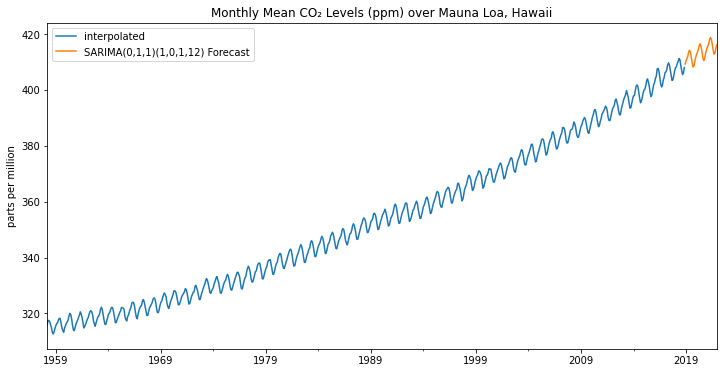

In [ ]:
# Plot predictions against known values
title = 'Monthly Mean CO₂ Levels (ppm) over Mauna Loa, Hawaii'
ylabel='parts per million'
xlabel=''

ax = df['interpolated'].plot(legend=True,figsize=(12,6),title=title)
fcast.plot(legend=True)
ax.set(xlabel=xlabel, ylabel=ylabel);